In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import xgboost
from sklearn.model_selection import GroupKFold, KFold
import uuid
import seaborn as sns

In [2]:
train  = pd.read_pickle('Feat5_119_oct_1_feats_train_More_items_past.pkl')
test = pd.read_pickle('Feat5_119_oct_1_feats_test_More_items_past.pkl')

In [3]:
#train.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)
#test.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)

In [4]:
# train['duration'] = train['duration'].dt.days
# test['duration'] = test['duration'].dt.days

In [5]:
campaignData = pd.read_csv('campaign_data.csv')
campaignData['start_date'] = pd.to_datetime(campaignData['start_date'], format= '%d/%m/%y')
campaignData['end_date'] = pd.to_datetime(campaignData['end_date'], format= '%d/%m/%y')
campaignData = campaignData.sort_values(by = 'start_date')
testCamp = test.campaign_id.unique()
trainCamp = train.campaign_id.unique()
campaignData['TrainOrTest'] = campaignData['campaign_id'].apply(lambda x : 'Train' if x in trainCamp else 'Test')

In [6]:
train.info(max_cols= 200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 132 columns):
id                               78369 non-null int64
campaign_id                      78369 non-null int64
coupon_id                        78369 non-null int64
customer_id                      78369 non-null int64
redemption_status                78369 non-null int64
item_id_nunique                  78369 non-null int64
item_id_mode                     78369 non-null int64
quantity_mean                    78369 non-null float64
quantity_nunique                 78369 non-null int64
quantity_mode                    78369 non-null int64
quantity_std                     78369 non-null float64
quantity_max_                    78369 non-null int64
selling_price_mean               78369 non-null float64
selling_price_max_               78369 non-null float64
selling_price_min_               78369 non-null float64
selling_price_std                78369 non-null float64
other_discount

In [7]:
target = 'redemption_status'
cat = ['campaign_type', 'brand_type_mode', 'brand_type_category_mode', 'brand_category_mode', 
      'CoupBrandTypeMode', 'age_range', 'marital_status']

In [8]:
moreCat = [x for x in train.columns if ('mode' in x.lower())]

In [9]:
cat = list(set(cat + moreCat))

In [10]:
# All = train.append(test)

In [11]:
# def one_hot_encoder(df, nan_as_category = False):
#     original_columns = list(df.columns)
#     categorical_columns = cat
#     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
#     new_columns = [c for c in df.columns if c not in original_columns]
#     return df, new_columns
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))

In [12]:
#All, newCols = one_hot_encoder(All, nan_as_category=True)

In [13]:
# train = All[~All.redemption_status.isnull()]
# test = All[All.redemption_status.isnull()]

In [14]:
toDrop = [x for x in train.columns if train[x].nunique() == 1]

In [15]:
moreToDrop = [x for x in train.columns if x.startswith('Coup')]
#moreToDrop = []

In [16]:
notTrainOn = ['id', 'campaign_id']
trainOn = [x for x in train.columns if (x not in notTrainOn ) & (x not in toDrop) & (x!=target) & (x not in moreToDrop)]

In [17]:
catIndex = [i for i,_ in enumerate(trainOn) if _ in cat]

In [18]:
gkf = KFold(n_splits=5)

In [19]:
catIndex = [i for i,x in enumerate(trainOn) if x in cat]

In [20]:
#trainOn.remove('itemPastIsCouponDiscMean')

In [21]:
oof = np.zeros_like(train[target])
oot = np.zeros_like(test['id']).astype('float')
feature_importance_df = pd.DataFrame()
oof = np.zeros_like(train[target])
oot = np.zeros_like(test['id']).astype('float')
feature_importance_df = pd.DataFrame()
oof = oof.astype('float')

In [22]:
def getResultSummary(res):
    trainMean = np.mean(list(map(lambda x : x[0], res)))
    validMean = np.mean(list(map(lambda x : x[1], res)))
    trainStd = np.std(list(map(lambda x : x[0], res)))
    validStd = np.std(list(map(lambda x : x[1], res)))
    return {
        
        'Train Mean' : trainMean, 
        'Valid Mean' : validMean, 
        'Train Std'  : trainStd,
        'Valid Std'  : validStd
    }

In [23]:
import catboost as cbg

In [24]:
import lightgbm as lgb

In [25]:
for x in cat:
    train[cat] = train[cat].astype('str')
    test[cat] = test[cat].astype('str')

In [26]:
results = []
featureImp = []
i = 0
for train_index, test_index in gkf.split(train[trainOn], train[target]):
    train_X = train.iloc[train_index][trainOn]
    valid_X = train.iloc[test_index][trainOn]
    train_y = train.iloc[train_index][target]
    valid_y = train.iloc[test_index][target]
    model = cbg.CatBoostClassifier(iterations=2500, eval_metric='AUC', random_state=1234567884, od_wait=400, colsample_bylevel=0.6, learning_rate=0.03)
    model.fit(train_X, train_y,  eval_set= [(train_X, train_y), 
                                        (valid_X, valid_y)],
                            verbose = 100, cat_features = catIndex)
    valid_pred = model.predict_proba(valid_X)[:,1]
    train_pred = model.predict_proba(train_X)[:,1]
    trainRes = roc_auc_score(train_y, train_pred)
    validRes = roc_auc_score(valid_y, valid_pred)
    oof[test_index] = valid_pred
    ootPred = model.predict_proba(test[trainOn])[:,1]
    oot += ootPred / 5
    results.append((trainRes, validRes))
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = trainOn
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    i+=1

0:	test: 0.8683905	test1: 0.8452891	best: 0.8452891 (0)	total: 214ms	remaining: 8m 55s
100:	test: 0.9412697	test1: 0.9382541	best: 0.9383945 (97)	total: 6.63s	remaining: 2m 37s
200:	test: 0.9495828	test1: 0.9428248	best: 0.9428248 (200)	total: 13.3s	remaining: 2m 31s
300:	test: 0.9540721	test1: 0.9451143	best: 0.9452569 (280)	total: 20s	remaining: 2m 25s
400:	test: 0.9579005	test1: 0.9477284	best: 0.9477284 (400)	total: 30.4s	remaining: 2m 39s
500:	test: 0.9617883	test1: 0.9506211	best: 0.9506318 (499)	total: 44.1s	remaining: 2m 55s
600:	test: 0.9647948	test1: 0.9527496	best: 0.9527496 (600)	total: 53.6s	remaining: 2m 49s
700:	test: 0.9679342	test1: 0.9546044	best: 0.9546599 (697)	total: 1m 1s	remaining: 2m 38s
800:	test: 0.9708058	test1: 0.9557246	best: 0.9557304 (799)	total: 1m 10s	remaining: 2m 28s
900:	test: 0.9730925	test1: 0.9566940	best: 0.9567177 (887)	total: 1m 22s	remaining: 2m 25s
1000:	test: 0.9754865	test1: 0.9583298	best: 0.9583628 (999)	total: 1m 29s	remaining: 2m 14s
11

900:	test: 0.9747148	test1: 0.9551335	best: 0.9551784 (891)	total: 1m 16s	remaining: 2m 15s
1000:	test: 0.9768237	test1: 0.9552333	best: 0.9554908 (995)	total: 1m 24s	remaining: 2m 6s
1100:	test: 0.9787561	test1: 0.9564398	best: 0.9565037 (1099)	total: 1m 33s	remaining: 1m 58s
1200:	test: 0.9806769	test1: 0.9567961	best: 0.9568306 (1198)	total: 1m 41s	remaining: 1m 49s
1300:	test: 0.9822696	test1: 0.9574427	best: 0.9574667 (1296)	total: 1m 48s	remaining: 1m 40s
1400:	test: 0.9841515	test1: 0.9570949	best: 0.9577338 (1311)	total: 1m 56s	remaining: 1m 31s
1500:	test: 0.9854797	test1: 0.9567553	best: 0.9577338 (1311)	total: 2m 4s	remaining: 1m 22s
1600:	test: 0.9865963	test1: 0.9567458	best: 0.9577338 (1311)	total: 2m 11s	remaining: 1m 14s
1700:	test: 0.9876271	test1: 0.9569757	best: 0.9577338 (1311)	total: 2m 19s	remaining: 1m 5s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.9577337836
bestIteration = 1311

Shrink model to first 1312 iterations.
0:	test: 0.9052753	

In [27]:
getResultSummary(results)

{'Train Mean': 0.9894723897277611,
 'Valid Mean': 0.9525158411595493,
 'Train Std': 0.004618977335332208,
 'Valid Std': 0.0101525218702882}

In [28]:
results

[(0.9933520896892334, 0.9644178829505616),
 (0.9929332893229829, 0.935187307024315),
 (0.9932063372560413, 0.9478147473574302),
 (0.9824553020736861, 0.9577337835926193),
 (0.9854149302968626, 0.9574254848728202)]

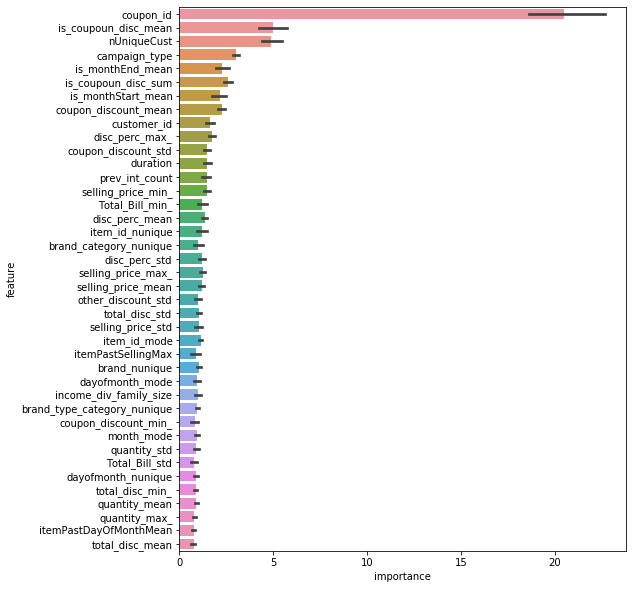

In [29]:
display_importances(feature_importance_df)

In [30]:
def saveStackingFile(prefix):
    oof_ = pd.DataFrame(oof,columns = [prefix])
    oot_ = pd.DataFrame(oot,columns = [prefix])
    print(oof_.shape, oot_.shape)
    oof_.to_csv(prefix + '_train.csv', index = False)
    oot_.to_csv(prefix + '_test.csv', index = False)

In [31]:
saveStackingFile('CGB_Feat5_Extra_Past_Item_5_Fold')

(78369, 1) (50226, 1)


In [ ]:
test[target] = oot

In [ ]:
fileName = str(uuid.uuid4()).split('-')[-1]

In [121]:
test[['id', target]].to_csv(fileName + '.csv', index = False)